In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
m = r"meal_info.csv"
t = r"train.csv"



In [3]:
meal = pd.read_csv(m)
train = pd.read_csv(t)



In [4]:
train.keys()

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

In [5]:
meal.keys()

Index(['meal_id', 'category', 'cuisine'], dtype='object')

In [6]:
merg = train.merge(meal, on='meal_id', how='left')
merg

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian


In [7]:
merg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 38.3+ MB


In [8]:
merg.keys()


Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine'],
      dtype='object')

In [9]:
# Use dataframe 'merg' for data processing
df = merg.copy()

In [10]:
# Feature Selection - Keeping relevant columns
features = ['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 
            'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category', 'cuisine']

df = df[features + ['num_orders']]  # Include target variable 'num_orders' for forecasting

# Encode categorical variables (category, cuisine) using one-hot encoding
df = pd.get_dummies(df, columns=['category', 'cuisine'], drop_first=True)

# Define features (X) and target variable (y)
X = df.drop(columns=['num_orders'])  # Features
y = df['num_orders']  # Target (forecasting number of orders)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train a Random Forest Regressor model
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Train the best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [17]:
# Make predictions
y_pred = best_model.predict(X_test)

In [19]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [21]:
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Absolute Error: 80.33
Mean Squared Error: 29932.21
R-squared Score: 0.80


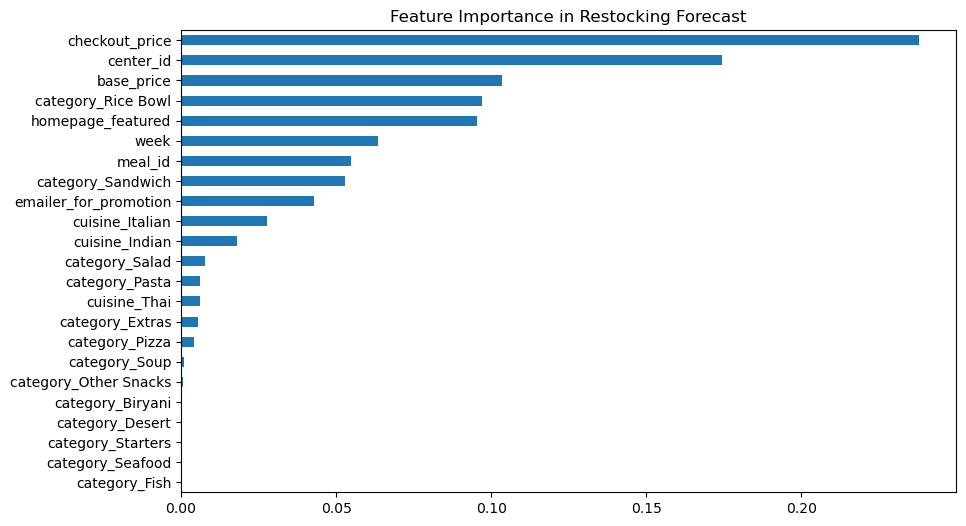

In [25]:
# Feature Importance Visualization
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance in Restocking Forecast")
plt.show()



In [27]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


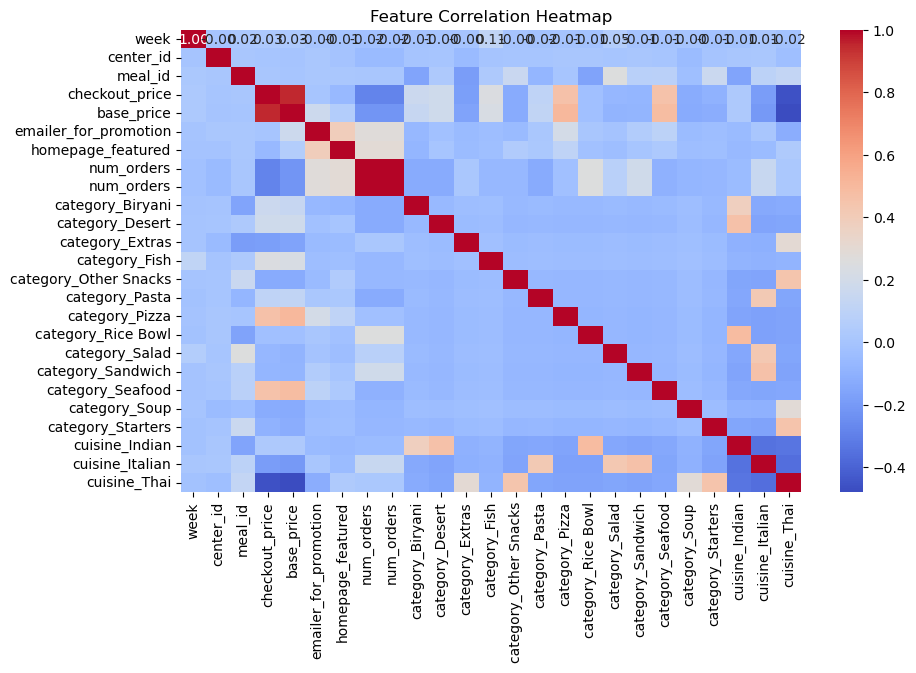

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()